In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Charger le jeu de données

df = pd.read_csv('dataset_test4.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist()
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


xgboost_pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = xgboost_pipeline.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(accuracy, report)


0.9451621369415607               precision    recall  f1-score   support

      CHGOFF       0.88      0.84      0.86     27801
       P I F       0.96      0.97      0.97    109367

    accuracy                           0.95    137168
   macro avg       0.92      0.91      0.91    137168
weighted avg       0.94      0.95      0.94    137168



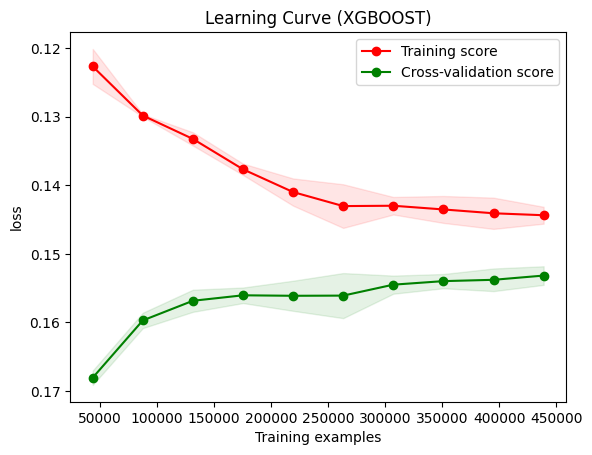

In [3]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = xgboost_pipeline,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'neg_log_loss'
)

#recuperation des moyennes et des écarts types(facultatif) à chaque cv
train_scores_mean = -train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)


plt.figure()
plt.title("Learning Curve (XGBOOST)")
plt.xlabel("Training examples")
plt.ylabel("loss")
plt.gca().invert_yaxis() #inverser y car métrique de perte

# afficher les points
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")


plt.legend()
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Charger le jeu de données

df = pd.read_csv('dataset_test4.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist()
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


xgb_param_grid = {
    'classifier__learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'classifier__n_estimators': [100],  # Nombre d'arbres
    'classifier__max_depth': [3, 4, 6],  # Profondeur maximale de chaque arbre
    'classifier__min_child_weight': [1, 3, 5],  # Poids minimum des instances nécessaires dans un enfant
    'classifier__subsample': [0.6, 0.8, 1.0],  # Fraction des échantillons à utiliser pour construire chaque arbre
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Fraction des caractéristiques à utiliser pour construire chaque arbre
    'classifier__reg_alpha': [0, 0.01, 0.1],  # Terme de régularisation L1 (alpha)
    'classifier__reg_lambda': [1, 1.5, 2],  # Terme de régularisation L2 (lambda)
}

grid_search = GridSearchCV(xgboost_pipeline, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Prédire les étiquettes sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(accuracy, report)


KeyboardInterrupt: 

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Charger le jeu de données
df = pd.read_csv('dataset_test4.csv')

# Sélectionner les variables indépendantes et la variable cible
X = df.drop('MIS_Status', axis=1)
y = df['MIS_Status']

# Encoder la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identifier les variables catégorielles et numériques
cat_vars = X.select_dtypes(include=['object']).columns.tolist()
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Créer les transformateurs pour les pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

# Combiner les transformateurs dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Créer la pipeline de traitement et de modélisation
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
])

# Séparer les données en ensembles d'entraînement et de test, stratifier sur y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ajuster la pipeline sur les données d'entraînement
xgboost_pipeline.fit(X_train, y_train)

#obtenir le nombre de caractéristiques transformées
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"Nombre de caractéristiques après le prétraitement : {len(feature_names)}")

# Prédire les étiquettes sur l'ensemble de test
y_pred = xgboost_pipeline.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(accuracy)
print(report)


Nombre de caractéristiques après le prétraitement : 114


/home/utilisateur/Bureau/brief_classif_sba/ml/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9451621369415607
              precision    recall  f1-score   support

      CHGOFF       0.88      0.84      0.86     27801
       P I F       0.96      0.97      0.97    109367

    accuracy                           0.95    137168
   macro avg       0.92      0.91      0.91    137168
weighted avg       0.94      0.95      0.94    137168



In [5]:
# Obtenir les importances des caractéristiques du modèle XGBoost
feature_importances = xgboost_pipeline.named_steps['classifier'].feature_importances_

# Obtenir les noms des caractéristiques transformées
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Afficher les importances des caractéristiques
print(importance_df)

               Feature  Importance
2            num__Term    0.119692
104  cat__BankState_VA    0.048926
61   cat__BankState_CA    0.039207
85   cat__BankState_NC    0.034392
33       cat__State_NC    0.032997
..                 ...         ...
14       cat__State_DE    0.000000
97   cat__BankState_PR    0.000000
68   cat__BankState_GU    0.000000
76   cat__BankState_LA    0.000000
57   cat__BankState_AK    0.000000

[114 rows x 2 columns]
